In [2]:


from BTSensor import (
    
)
import numpy as np
import os
import h5py
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import cm as cmap
from matplotlib import colors
from matplotlib.colors import Normalize
from mpl_toolkits import mplot3d

import uxo_utils
from uxo_utils import (
    SensorInfo, Model, preCalcLoopCorners, FModParam, 
    forwardWithQ, sensorCoords2RxCoords, hprimary, formQmatrix
)

In [3]:
from matplotlib import rcParams
rcParams['font.size'] = 14
# np.random.seed(2020)

## load sensor info and ordnance data

In [4]:
sensor_info = uxo_utils.load_sensor_info
ord_dict = uxo_utils.load_ordnance_dict()

print(ord_dict.keys())

dict_keys(['105mm', '2.36-in', '2.75-in', '2.95-in', '20-lb Bomb', '25-lb Bomb', '3-in', '3.5-in', '30mm', '37mm', '4-in', '4-in Sphere', '4.2-in', '4.5-in', '4.52-in', '5-lb Bomb', '57mm', '60mm', '66mm', '75mm', '76mm', '81mm', '90mm', '106mm', 'ISO Large', 'ISO Medium', 'ISO Small', '2.25-in'])


In [13]:
ord_dict["ISO Small"]["common_name"][0][0]

b'Small ISO80'

## set up survey parameters
- x is cross-line
- y is inline

In [5]:
ntx = len(sensorinfo.transmitters)
ymax = 1
y_spacing = 0.2
dy = y_spacing / ntx
nloc = int(ymax/dy)
ncycles = int(nloc/ntx)

y = np.linspace(0, ymax-dy, nloc)
x = np.zeros(nloc)
z = 0.28 * np.ones(nloc)

pitch = np.zeros(nloc)
roll = np.zeros(nloc)
yaw = np.zeros(nloc)  # moving north (sensor in typical orientation)

txnum = np.kron(np.ones(ncycles), np.arange(ntx))

In [6]:
nloc/ntx

5.0

In [7]:
ncycles

5

In [8]:
# Convert sensor location coordinates to Rx locations
pos, mnum = sensorCoords2RxCoords(
    sensorinfo=sensorinfo,
    x = x, 
    y = y, 
    z = z, 
    pitch = pitch, 
    roll = roll, 
    yaw = yaw,
    txnum = txnum
)

pitch = np.concatenate([np.tile(x,pos[i].shape[0]) for i,x in enumerate(pitch)])
roll = np.concatenate([np.tile(x,pos[i].shape[0]) for i,x in enumerate(roll)])
yaw = np.concatenate([np.tile(x,pos[i].shape[0]) for i,x in enumerate(yaw)])
pos = np.concatenate(pos,axis=0)

In [9]:
for i in range(3):
    print(pos[:, i].min(), pos[:, i].max())

-1.0 1.0
-0.25 1.21
0.28 0.28


# ordnance objects

In [10]:
# filename = "ordnance_DoD_UltraTEM_5F_APG.h5"
# ord_file = os.path.join(code_dir, filename)
# f = h5py.File(ord_file, 'r')

In [12]:
path_comp = [x for x in f['ordnance'] if 'ISO Large'==f['ordnance/{}/Name'.format(x)][()][0].decode("utf-8")]
path_comp

['611', '612', '613', '614', '615', '616', '617', '618']

In [22]:
# Load the ordnance objects

def load_ord(filename="ordnance_DoD_UltraTEM_5F_ISOsmall.h5", ordi=1):
    ord_file = os.path.join(code_dir, filename)
    f = h5py.File(ord_file, 'r')
    ord_name = str(f['ordnance/{}/Name'.format(ordi)][()][0]).split("'")[1]
    ord_dict = {
        "L3": f[f'ordnance/{ordi}/L1ref'][()].flatten(),
        "L2": f[f'ordnance/{ordi}/L2ref'][()].flatten(),
        "L1": f[f'ordnance/{ordi}/L3ref'][()].flatten(),
        "times": f[f'ordnance/{ordi}/time'][()].flatten()
    }
    f.close()
    return ord_name, ord_dict

In [23]:
ordnance = {}
for f in ["ordnance_DoD_UltraTEM_5F_ISOsmall.h5", "ordnance_DoD_UltraTEM_5F_APG.h5"]:
    name, data = load_ord(f)
    ordnance[name] = data
times = ordnance["ISO Small"]["times"]

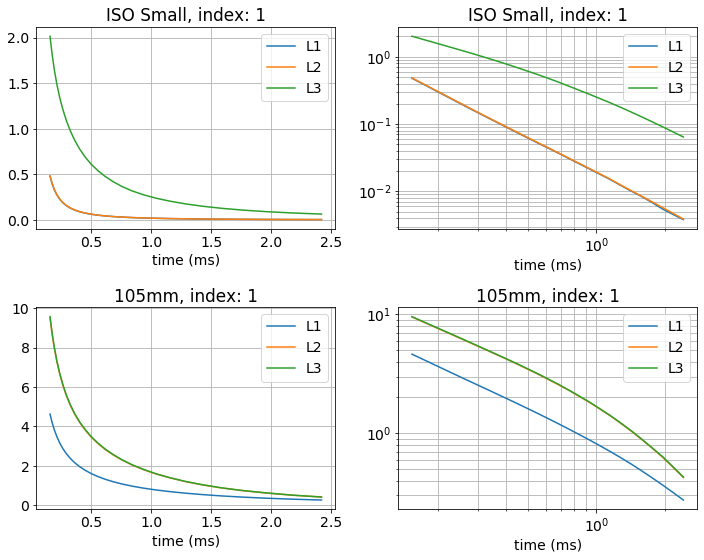

In [24]:
fig, ax = plt.subplots(len(ordnance.keys()), 2, figsize=(10, 4*len(ordnance.keys())))

for i, key in enumerate(ordnance.keys()):
    for l in ["L1", "L2", "L3"]:
        L = ordnance[key][l]
        ax[i, 0].plot(times, L, label=l)
        ax[i, 1].loglog(times, L, label=l)

    for a in ax[i, :]:
        a.set_title(f"{key}, index: {1}")
        a.grid(which="both")
        a.legend()
        a.set_xlabel("time (ms)")
plt.tight_layout()

# ranges of parameters

In [25]:
depth_range_iso_small = np.r_[0.2, 0.7]
depth_range_105mm = np.r_[0.1, 0.5]

x_range = np.r_[-1.25, 1.25]
y_range = np.r_[0., ymax]

yaw_range = np.r_[0, 2*np.pi]
pitch_range = np.r_[0, 2*np.pi]
roll_range = np.r_[0, 2*np.pi]

def generate_random_variables(n, bounds):
    return bounds.min() + (bounds.max() - bounds.min()) * np.random.rand(n)

In [26]:
ntrain = 2048
ntest = 1024
nvalid = 1024

class_dict = {
    0: "not TOI",
    1: "ISO Small",
    2: "105mm"
}
n_class = len(class_dict.keys())

In [27]:
labels_train = np.random.choice(n_class, ntrain)
labels_test = np.random.choice(n_class, ntest)
labels_valid = np.random.choice(n_class, nvalid)

def generate_parameters(labels):
    n = len(labels)
    i0 = labels == 0
    i1 = labels == 1
    i2 = labels == 2
    
    depths = np.zeros(n)
    depths[i1] = generate_random_variables(i1.sum(), depth_range_iso_small)
    depths[i2] = generate_random_variables(i2.sum(), depth_range_105mm)
    
    x = generate_random_variables(n, x_range)
    y = generate_random_variables(n, y_range)
    z = -depths
    
    yaw = generate_random_variables(n, yaw_range)
    pitch = generate_random_variables(n, pitch_range)
    roll = generate_random_variables(n, roll_range)
    
    return pd.DataFrame({
        "label": labels,
        "depth": depths,
        "x": x,
        "y": y,
        "z": z,
        "yaw": yaw,
        "pitch": pitch,
        "roll": roll
    })

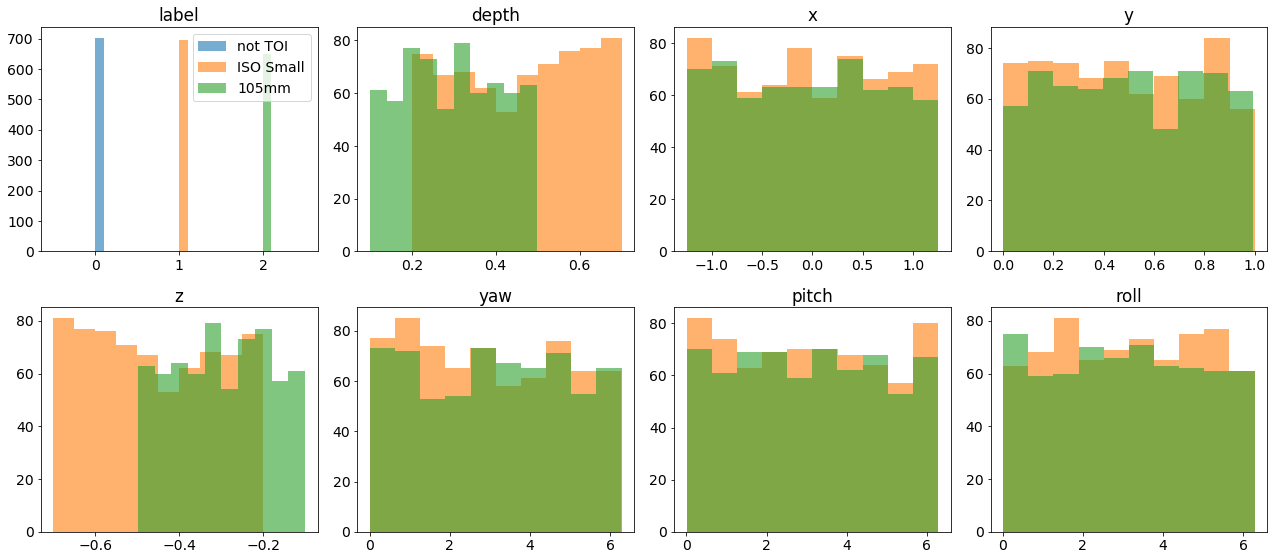

In [28]:
params_train = generate_parameters(labels_train) 
params_test = generate_parameters(labels_test) 
params_valid = generate_parameters(labels_valid) 

fig, ax = plt.subplots(2, 4, figsize=(18, 8))
ax = ax.flatten()

i = 0
for key, val in params_train.items():
    for j in range(3):
        if key != "label" and j ==0: 
            pass  # these parameters are irrelevant if there is no object
        else:
            inds = labels_train == j
            ax[i].hist(val[inds], 10, color=f"C{j}", alpha=0.6)
    ax[i].set_title(key)
    i += 1

ax[0].legend([class_dict[0], class_dict[1], class_dict[2]])
plt.tight_layout()

# set up forward simulations

In [29]:
# figuring out where all of the vertices are in coordinate system -- gives us location of vertices 
Tx_indices_rot, Rx_indices_rot = preCalcLoopCorners(
    sensorinfo=sensorinfo, mnum=mnum, rlist=pos, pitch=pitch, roll=roll, yaw=yaw
) 

# convienence object for inputs to fwd modelling 
st = FModParam(sensorinfo, pos, mnum, times, Tx_indices_rot, Rx_indices_rot)  

In [30]:
def run_simulations(parameters, st=st, mnum=mnum, ncycles=ncycles):
    data = []
    for i, l in enumerate(parameters["label"]):
        if l == 0:
            # this can later be replaced with random noise or other structured but uninteresting signal
            V = np.zeros((pos.shape[0], len(times)))
        else: 
            xyz = np.r_[parameters["x"][i], parameters["y"][i], parameters["z"][i]]
            ypr = np.r_[parameters["yaw"][i], parameters["pitch"][i], parameters["roll"][i]]
            L3 = ordnance[class_dict[l]]["L3"]
            L2 = ordnance[class_dict[l]]["L2"]
            L1 = ordnance[class_dict[l]]["L1"]
            
            mod = Model(xyz=xyz, gba=ypr, l3=L3, l2=L2, l1=L1, times=times)
            V = forwardWithQ(mod, st) # nT/s (some version of db/dt)
        V = V.reshape(ncycles, mnum.max()+1, len(times))
        V = np.swapaxes(V, 0, 1)
        data.append(V)
    return data
    
    

In [31]:
%%time
data_train = run_simulations(params_train)

CPU times: user 4.78 s, sys: 336 ms, total: 5.11 s
Wall time: 1.3 s


In [32]:
%%time
data_test = run_simulations(params_test)
data_valid = run_simulations(params_valid)

CPU times: user 5.56 s, sys: 388 ms, total: 5.94 s
Wall time: 1.53 s


## plot some sample data

In [33]:
pos = np.swapaxes(pos.reshape(ncycles, mnum.max()+1, 3), 0, 1)

In [34]:
dind = 2
d = data_train[dind]

print(f"class: {class_dict[labels_train[dind]]}, data shape: {d.shape}")

params_train.iloc[dind]

class: ISO Small, data shape: (165, 5, 27)


label    1.000000
depth    0.624970
x        0.824471
y        0.088224
z       -0.624970
yaw      0.513471
pitch    3.580980
roll     4.713075
Name: 2, dtype: float64

In [35]:
# tx_num, rx_num, rx_comp, rxcube
sensor_table = sensorinfo.measNum2TxRxRxcCube()

In [36]:
len(sensor_table)

165

Text(0.5, 0.92, 'Transmitter 5, Target 2: ISO Small')

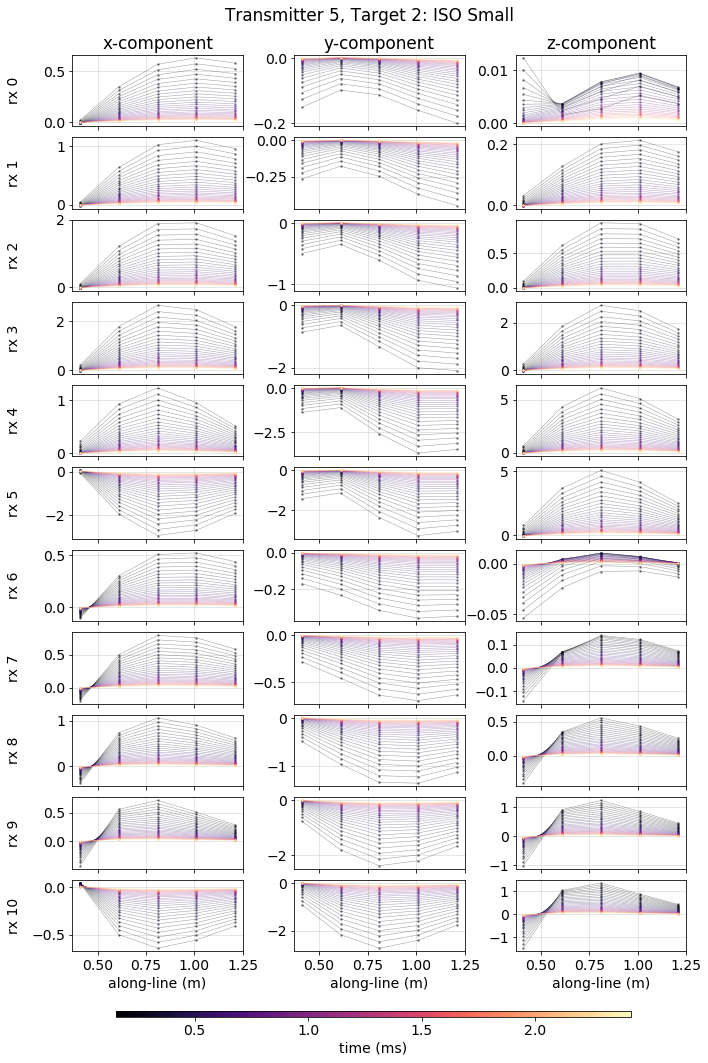

In [37]:
nrx = 11
fig, ax = plt.subplots(nrx, 3, figsize=(11, 1.5*nrx))
fig.subplots_adjust(wspace=0.3, hspace=0.15)

plot_tx = 4
tx_inds = (sensor_table[:, 0] == plot_tx)

cm = plt.get_cmap('magma')
c_norm = Normalize(vmin=times.min(), vmax=times.max())
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

for rx in range(nrx):
    ii = tx_inds & (sensor_table[:, 3] == rx)
    for a, comp in zip(ax[rx, :], [0, 1, 2]):
        mnumind = np.where( ii & (sensor_table[:, 2] == comp))[0][0]
        for t in range(len(times)):
            a.plot(
                pos[mnumind, :, 1], d[mnumind, :, t], 
                color=scalar_map.to_rgba(times[t]), marker=".", lw=0.5, alpha=0.4, ms=3
            )

        a.grid(which="both", alpha=0.4)
        if rx < nrx-1:
            a.set_xticklabels('')
        else:
            a.set_xlabel("along-line (m)")
        
        if rx == 0:
            if comp == 0:
                a.set_title("x-component")
            elif comp == 1:
                a.set_title("y-component")
            elif comp == 2:
                a.set_title("z-component")
        
        if comp == 0:
            a.set_ylabel(f"rx {rx}")
            a.yaxis.set_label_coords(-0.3, 0.5)
            
# plt.tight_layout()
cbar_ax = fig.add_axes([0.18, 0.07, 0.65, 0.005])
cb = plt.colorbar(scalar_map, cbar_ax, orientation="horizontal")
cb.set_label('time (ms)')

fig.suptitle(f"Transmitter {plot_tx+1}, Target {dind}: {class_dict[labels_train[dind]]}", y=0.92)


# build a CNN classifier 

In [38]:
import torch
from torch import nn
from torch.nn import functional

In [39]:
class ConvNet(nn.Module):
    
    def __init__(self, network_geometry, h=1, npool=3):
        super().__init__()
        self.h = h
        self.network_geometry=network_geometry
        self.nt = len(network_geometry)
#         self.npool = npool
    
    def forward(self, X, K, batch_norm):
            
        for i, Ki, bn in zip(range(self.nt), K, batch_norm): 
            z = functional.conv2d(X, Ki, stride=1, padding=1)
            z = bn(z)
            z = functional.relu(z)
            
#             for i in range(self.npool):
#                 z = functional.avg_pool2d(z, 2, stride=1, padding=1)
            
                
#             if self.network_geometry[i] == self.network_geometry[i+1]:
#                 z = functional.conv_transpose2d(z, Ki, stride=1, padding=1)
#                 X = X + self.h*z
#             else: 
            X = z
        return X

In [40]:
in_channels = 165
n_class = 3
layer_geometries = [in_channels, 4, 4]
nlayers = len(layer_geometries)
initial_scaling = 1e-3

width = nloc//ntx
ntimes = len(times)

batch_size = 32 
net = ConvNet(layer_geometries, h=1)

# initialize K's and batch normalizations
K = []
batch_norm = []
for i in range(nlayers-1):
    n_in = layer_geometries[i]
    n_out = layer_geometries[i+1]
    Ki = nn.Parameter(torch.Tensor(n_out, n_in, 3, 3))
    Ki.data = torch.randn(n_out, n_in, 3, 3)  * initial_scaling
    K.append(Ki)
    
    batch_norm.append(nn.BatchNorm2d(n_out))

# initialize classifier W
W = nn.Parameter(torch.Tensor(layer_geometries[-1]*width*ntimes, n_class))
W.data = torch.randn(layer_geometries[-1]*width*ntimes, n_class)*initial_scaling

In [41]:
net = ConvNet(layer_geometries)

In [42]:
X_train = torch.from_numpy(np.float32(np.stack(data_train, axis=0)))
X_test = torch.from_numpy(np.float32(np.stack(data_test, axis=0)))
X_valid = torch.from_numpy(np.float32(np.stack(data_valid, axis=0)))

C_train = torch.from_numpy(np.float32(labels_train)).long()
C_test = torch.from_numpy(np.float32(labels_test)).long()
C_valid = torch.from_numpy(np.float32(labels_valid)).long()

In [43]:
# run the network

with torch.no_grad():
    out = net(X_train, K, batch_norm)

In [44]:
loss_func = nn.CrossEntropyLoss()

def misfit(X, W, C):
    n = W.shape
    X = X.view(-1, n[0])
    S = torch.matmul(X, W)

    probs = functional.softmax(S, dim=1)
    return loss_func(S, C), probs

In [45]:
n_parout = (
    np.sum(np.array([np.prod(Ki.shape) for Ki in K])) + np.prod(W.shape)
)

print('Total number of parameters',n_parout)
print('Total number of data', labels_train.shape[0])

Total number of parameters 7704
Total number of data 2048


In [46]:
def accuracy(S, labels):
    _, predicted = torch.max(S, dim=1)
    total = np.prod(labels.size())
    correct = (predicted == labels).sum().item()
    return correct/total

In [47]:
loss, probs = misfit(out, W, C_train)
print('Initial loss = ', loss.detach().numpy())    
print(f'Check:log({n_class}) = ', np.log(n_class))

print(f"\nInitial accuracy: {accuracy(probs, C_train)}")
print(f"Check random    : {1/n_class}")

Initial loss =  1.0988785
Check:log(3) =  1.0986122886681098

Initial accuracy: 0.103515625
Check random    : 0.3333333333333333


In [48]:
batch_size = 32

In [49]:
import torch.optim as optim
optimizer = optim.SGD(
    [{'params': W}, {'params': K}], 
    lr = 1e0, momentum=0
)


In [50]:
all_loss = []
all_test_loss = []

for epoch in range(200):  # loop over the dataset multiple times

    # zero the parameter gradients
    g = 0.0
    loss = 0.0
    ind = 0
    
    while ind < X_train.shape[1]:    
        optimizer.zero_grad()
        # get the inputs
        inputs = X_train[ind:ind+batch_size, :, :, :]
        labels = C_train[ind:ind+batch_size]

        # forward 
        x = net(inputs, K, batch_norm)
        lossi, _ = misfit(x, W, labels)
        if i==0:
            loss = lossi
        else:
            loss += lossi
        lossi.backward()
        optimizer.step()
        ind += batch_size
    
    if np.mod(epoch, 10) == 0: 
        with torch.no_grad():
            xtest = net(X_test, K, batch_norm)
            loss_test, probs_test = misfit(xtest, W, C_test)

            xtrain = net(X_train, K, batch_norm)
            loss_train, probs_train = misfit(xtrain, W, C_train)

            accuracy_train = accuracy(probs_train, C_train)
            accuracy_test = accuracy(probs_test, C_test)

        print(f'{epoch+1:3d}  {loss:2.3f}  {loss_test:2.3f}  {accuracy_train:0.3f}  {accuracy_test:0.3f}')

print('Finished Training')

  1  23.424  1.317  0.598  0.615
 11  4.411  0.679  0.645  0.667
 21  3.370  0.573  0.691  0.715
 31  3.060  0.511  0.729  0.748
 41  2.722  0.432  0.788  0.806
 51  2.671  0.390  0.880  0.896
 61  2.522  0.455  0.794  0.797
 71  2.061  0.381  0.838  0.838
 81  1.848  0.282  0.891  0.893
 91  2.478  0.242  0.953  0.968
101  1.201  0.482  0.789  0.812
111  0.957  0.340  0.861  0.830
121  0.763  0.275  0.894  0.870
131  1.817  0.325  0.860  0.858
141  0.548  0.101  0.986  0.968
151  0.381  0.094  0.979  0.968
161  0.300  0.070  0.983  0.980
171  0.242  0.057  0.985  0.981
181  0.179  0.055  0.983  0.979
191  0.138  0.048  0.986  0.981
Finished Training


In [51]:
# training set
x_train_net = net(X_train, K, batch_norm)
_, probs_train = misfit(x_train_net, W, C_train)
_, pred_train = torch.max(probs_train, dim=1)

# test set
x_test_net = net(X_test, K, batch_norm)
_, probs_test = misfit(x_test_net, W, C_test)
_, pred_test = torch.max(probs_test, dim=1)

# validation set
x_valid_net = net(X_valid, K, batch_norm)
_, probs_valid = misfit(x_valid_net, W, C_valid)
_, pred_valid = torch.max(probs_valid, dim=1)

In [52]:
print(f"training accuracy: {accuracy(probs_train, C_train):1.4f}")
print(f"test accuracy    : {accuracy(probs_test, C_test):1.4f}")
print(f"valid accuracy   : {accuracy(probs_valid, C_valid):1.4f}")

training accuracy: 0.9849
test accuracy    : 0.9795
valid accuracy   : 0.9775


In [42]:
# see where it struggled

def get_mislabeled(S, labels):
    _, predicted = torch.max(S, dim=1)
    incorrect = (predicted != labels)
    return incorrect.numpy()

In [43]:
mislabeled_train = get_mislabeled(probs_train, C_train)
mislabeled_test = get_mislabeled(probs_test, C_test)
mislabeled_valid = get_mislabeled(probs_valid, C_valid)

print(f"Mislabeled. train: {mislabeled_train.sum()}, test: {mislabeled_test.sum()}, valid: {mislabeled_valid.sum()}")

Mislabeled. train: 47, test: 34, valid: 22


In [44]:
params_train.loc[mislabeled_train]

,label,depth,x,y,z,yaw,pitch,roll
160,1,0.547734,0.787538,0.020919,-0.547734,1.576502,5.131850,1.195324
164,1,0.571999,-1.148605,1.107935,-0.571999,3.357486,1.930136,5.546942
168,2,0.439738,-1.231953,0.266956,-0.439738,1.432471,0.896646,5.017198
180,2,0.349827,1.186390,0.383372,-0.349827,5.252338,1.742359,2.552307
187,1,0.644960,0.516002,2.709763,-0.644960,4.721134,5.093632,1.393814
278,1,0.671102,-0.947156,1.210034,-0.671102,0.580294,4.462738,2.254373
295,1,0.637534,-1.120480,1.881498,-0.637534,5.216149,0.931443,5.930958
326,2,0.463211,1.142696,0.464144,-0.463211,0.542455,6.193493,3.069672
343,1,0.675032,0.577681,2.703668,-0.675032,0.985057,1.655523,3.752226
350,2,0.450140,1.189728,0.142868,-0.450140,0.736658,5.749494,1.470785


In [45]:
probs_train[mislabeled_train]

tensor([[7.5119e-01, 2.4881e-01, 2.2417e-07],
        [9.6321e-01, 3.6792e-02, 3.5941e-08],
        [3.4643e-26, 9.9972e-01, 2.7853e-04],
        [1.5091e-25, 9.6832e-01, 3.1685e-02],
        [7.6172e-01, 2.3828e-01, 3.4406e-07],
        [9.8291e-01, 1.7088e-02, 2.0636e-08],
        [9.1828e-01, 8.1716e-02, 1.0389e-07],
        [3.0402e-26, 9.9738e-01, 2.6168e-03],
        [7.3056e-01, 2.6944e-01, 1.4956e-07],
        [7.2203e-22, 9.9761e-01, 2.3868e-03],
        [1.2867e-21, 9.4525e-03, 9.9055e-01],
        [1.1294e-18, 1.9574e-03, 9.9804e-01],
        [9.9809e-19, 3.8524e-01, 6.1476e-01],
        [9.9624e-01, 3.7616e-03, 1.1565e-08],
        [9.4147e-01, 5.8533e-02, 5.7833e-08],
        [6.1935e-01, 3.8065e-01, 3.0358e-07],
        [7.3022e-35, 9.8680e-01, 1.3200e-02],
        [9.9579e-01, 4.2145e-03, 9.6311e-09],
        [5.3434e-34, 8.6522e-01, 1.3478e-01],
        [1.0249e-35, 9.8313e-01, 1.6866e-02],
        [1.7255e-19, 1.1505e-01, 8.8495e-01],
        [2.0682e-23, 9.3602e-01, 6

In [46]:
params_test.loc[mislabeled_test]

,label,depth,x,y,z,yaw,pitch,roll
8,2,0.135768,-0.322446,1.572155,-0.135768,1.748341,0.566470,1.001471
56,1,0.646059,-1.204115,2.756482,-0.646059,5.057276,2.347078,6.025054
60,2,0.494308,-1.084816,0.621939,-0.494308,4.758861,1.432310,0.752169
99,1,0.628183,1.080833,0.837726,-0.628183,5.185738,1.780860,5.303923
109,1,0.697793,-1.071849,2.930224,-0.697793,2.152095,1.452220,3.841564
113,1,0.578113,1.234945,0.878426,-0.578113,4.173205,4.343398,4.237239
142,1,0.238289,-0.801205,0.445205,-0.238289,1.717079,6.071329,3.709115
220,1,0.623152,0.416597,0.210382,-0.623152,1.585272,2.090832,4.471152
243,1,0.697154,-0.843486,0.128167,-0.697154,4.920501,1.116054,1.771425
246,1,0.664170,-0.942766,0.858903,-0.664170,0.020815,1.209951,3.895328


In [47]:
probs_test[mislabeled_test]

tensor([[0.0000e+00, 9.6096e-01, 3.9041e-02],
        [9.7355e-01, 2.6451e-02, 1.1787e-07],
        [3.5801e-32, 9.9451e-01, 5.4862e-03],
        [8.7238e-01, 1.2762e-01, 8.3104e-08],
        [9.9933e-01, 6.7355e-04, 3.9977e-09],
        [5.8281e-01, 4.1719e-01, 2.2038e-07],
        [1.5774e-28, 4.5076e-02, 9.5492e-01],
        [5.3580e-01, 4.6420e-01, 2.6668e-07],
        [9.8394e-01, 1.6061e-02, 2.6325e-08],
        [9.9166e-01, 8.3350e-03, 1.4741e-08],
        [0.0000e+00, 1.0000e+00, 1.2530e-08],
        [9.3619e-01, 6.3807e-02, 8.5168e-08],
        [6.4423e-20, 3.1518e-03, 9.9685e-01],
        [9.5530e-01, 4.4705e-02, 8.7780e-08],
        [5.3781e-36, 5.4935e-01, 4.5065e-01],
        [8.9294e-01, 1.0706e-01, 1.2165e-07],
        [9.9571e-01, 4.2902e-03, 7.8330e-09],
        [9.9299e-01, 7.0099e-03, 2.2857e-08],
        [9.8974e-01, 1.0262e-02, 1.7554e-08],
        [9.8873e-01, 1.1268e-02, 6.0471e-08],
        [5.4358e-01, 4.5641e-01, 1.0138e-06],
        [9.8565e-01, 1.4351e-02, 6

In [48]:
params_valid.loc[mislabeled_valid]

,label,depth,x,y,z,yaw,pitch,roll
79,1,0.656544,-1.157368,0.617576,-0.656544,2.442690,1.534841,4.481752
88,2,0.482352,1.176949,0.733121,-0.482352,4.069532,3.679373,0.154539
101,1,0.246239,0.857356,2.140009,-0.246239,0.001618,6.172996,3.290186
226,1,0.208578,-0.287836,0.258062,-0.208578,3.163001,0.402954,3.519647
247,2,0.418943,1.224796,0.653927,-0.418943,4.571886,1.941340,6.063451
271,1,0.523533,1.185189,0.318926,-0.523533,2.143837,1.404208,0.417387
344,1,0.284507,0.095522,2.988421,-0.284507,2.795508,4.381807,2.703700
345,2,0.448947,-1.182570,0.443629,-0.448947,0.642620,1.596403,6.144655
355,2,0.426539,-1.161164,0.133636,-0.426539,5.483494,3.956229,2.705227
516,1,0.202596,0.762842,0.831502,-0.202596,2.717562,2.535039,3.457365


In [49]:
probs_valid[mislabeled_valid]

tensor([[6.0628e-01, 3.9372e-01, 2.5117e-07],
        [3.0196e-27, 9.9939e-01, 6.1175e-04],
        [1.2981e-08, 4.7362e-02, 9.5264e-01],
        [1.0693e-15, 2.0855e-02, 9.7914e-01],
        [7.4996e-26, 9.9842e-01, 1.5777e-03],
        [8.0816e-01, 1.9184e-01, 1.8700e-07],
        [9.5982e-01, 4.0183e-02, 1.6890e-07],
        [3.7266e-27, 9.9083e-01, 9.1747e-03],
        [4.2147e-24, 9.9940e-01, 5.9807e-04],
        [1.2455e-19, 1.0937e-03, 9.9891e-01],
        [1.8503e-26, 9.9618e-01, 3.8188e-03],
        [9.2147e-01, 7.8529e-02, 1.0209e-07],
        [7.6546e-01, 2.3454e-01, 2.5514e-07],
        [2.9888e-12, 3.7154e-01, 6.2846e-01],
        [4.0973e-35, 6.4359e-01, 3.5641e-01],
        [9.9209e-01, 7.9142e-03, 1.3092e-08],
        [9.9488e-01, 5.1245e-03, 1.0658e-08],
        [9.6125e-01, 3.8748e-02, 4.3697e-08],
        [6.0966e-01, 3.9034e-01, 3.1515e-07],
        [9.6376e-01, 3.6240e-02, 1.0627e-07],
        [8.2913e-01, 1.7087e-01, 1.2844e-07],
        [5.0796e-14, 2.1895e-01, 7

# generate a line of data

In [50]:
ymax_profile = 30
nloc_profile = int(ymax_profile/dy)
ncycles_profile = int(nloc_profile/ntx)

y_profile = np.linspace(0, ymax_profile-dy, nloc_profile)
x_profile = np.zeros(nloc_profile)
z_profile = 0.28 * np.ones(nloc_profile)

pitch_profile = np.zeros(nloc_profile)
roll_profile = np.zeros(nloc_profile)
yaw_profile = np.zeros(nloc_profile)  # moving north (sensor in typical orientation)

txnum_profile = np.kron(np.ones(ncycles_profile), np.arange(ntx))

In [51]:
# Convert sensor location coordinates to Rx locations
pos_profile, mnum_profile = sensorCoords2RxCoords(
    sensorinfo=sensorinfo,
    x = x_profile, 
    y = y_profile, 
    z = z_profile, 
    pitch = pitch_profile, 
    roll = roll_profile, 
    yaw = yaw_profile,
    txnum = txnum_profile
)

pitch_profile = np.concatenate([np.tile(x,pos_profile[i].shape[0]) for i,x in enumerate(pitch_profile)])
roll_profile = np.concatenate([np.tile(x,pos_profile[i].shape[0]) for i,x in enumerate(roll_profile)])
yaw_profile = np.concatenate([np.tile(x,pos_profile[i].shape[0]) for i,x in enumerate(yaw_profile)])
pos_profile = np.concatenate(pos_profile,axis=0)

In [151]:
depths_profile = np.r_[0.1, 0.5, 0.2, 0.45, 0.7]
params_profile = pd.DataFrame({
    "label": [1, 1, 1, 1, 1],
    "depth": depths_profile,
    "x": np.r_[0, 0, 0, 0, 0],
    "y": np.r_[5, 10, 15, 20, 25],
    "z": -depths_profile,
    "yaw": np.r_[0, np.pi/4, 0, np.pi/4, np.pi/2],
    "pitch": np.r_[0, 0, 0, 0, 0],
    "roll": np.r_[0, 0, 0, 0, 0]
})
params_profile

,label,depth,x,y,z,yaw,pitch,roll
0,1,0.10,0,5,-0.10,0.000000,0,0
1,1,0.50,0,10,-0.50,0.785398,0,0
2,1,0.20,0,15,-0.20,0.000000,0,0
3,1,0.45,0,20,-0.45,0.785398,0,0
4,1,0.70,0,25,-0.70,1.570796,0,0


In [152]:
# figuring out where all of the vertices are in coordinate system -- gives us location of vertices 
Tx_indices_rot_profile, Rx_indices_rot_profile = preCalcLoopCorners(
    sensorinfo=sensorinfo, mnum=mnum_profile, rlist=pos_profile, pitch=pitch_profile, roll=roll_profile, yaw=yaw_profile
) 

# convienence object for inputs to fwd modelling 
st_profile = FModParam(sensorinfo, pos_profile, mnum_profile, times, Tx_indices_rot_profile, Rx_indices_rot_profile)  



In [153]:
data_profile = run_simulations(params_profile, st=st_profile, mnum=mnum_profile, ncycles=ncycles_profile)

In [154]:
data_profile[0].shape

(165, 150, 27)

In [155]:
X_profile = pos_profile[:, 0].reshape((165, ncycles_profile), order="F")
Y_profile = pos_profile[:, 1].reshape((165, ncycles_profile), order="F")


In [156]:
D_profile = sum(data_profile)
D_profile.shape

(165, 150, 27)

In [157]:
window_width_profile = int(ymax/y_spacing)
w_step_profile = 5
n_windows_profile = (X_profile.shape[1]-window_width_profile)//w_step_profile
print(n_windows_profile)

27


In [158]:
n = D_profile.shape
net_data_profile = np.zeros((n_windows_profile, n[0], window_width_profile, n[2]))
net_y_profile = np.zeros((n_windows_profile, n[0], window_width_profile))
net_x_profile = np.zeros((n_windows_profile, n[0], window_width_profile))

for i in range(n_windows_profile):
    inds = slice(i*w_step_profile,i*w_step_profile+window_width_profile)
    net_x_profile[i, :, :] = X_profile[:, inds]
    net_y_profile[i, :, :] = Y_profile[:, inds]
    net_data_profile[i, :, :, :] = D_profile[:, inds, :]

In [159]:
net_data_profile_torch = torch.from_numpy(np.float32(net_data_profile))

In [160]:
with torch.no_grad():
    out_field = net(net_data_profile_torch, K, batch_norm)
    n = W.shape
    S = torch.matmul(out_field.view(-1, n[0]), W)
    probs_profile = functional.softmax(S, dim=1)

In [161]:
_, labels_profile = torch.max(probs_profile, dim=1)

In [162]:
D_profile[mnum, :, :].shape

(2475, 150, 27)

In [163]:
from matplotlib.lines import Line2D

(-10, 10)

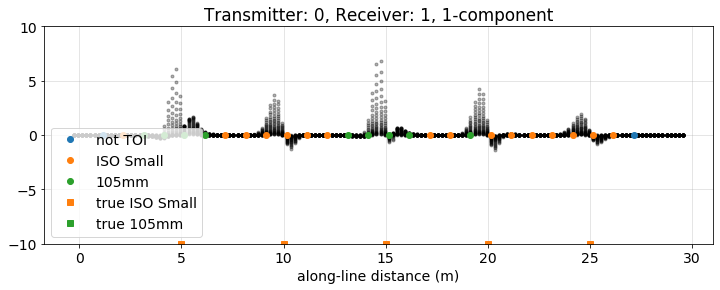

In [164]:
mnum_plot = 12
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

ordnance_labels = [
    Line2D(
        [0], [0], marker='o', color="w", 
        markerfacecolor=f'C{int(key)}', markeredgecolor=f'C{int(key)}', 
        label=value
    ) for key, value in class_dict.items()
]

ordnance_labels = ordnance_labels + [
    Line2D(
        [0], [0], marker='s', color="w", 
        markerfacecolor=f'C{int(key)}', markeredgecolor=f'C{int(key)}', 
        label=f"true {class_dict[key]}"
    ) for key in [1, 2]
]

ax.plot(Y_profile[mnum_plot, :], D_profile[mnum_plot, :, :], '.', color="k", alpha=0.3)
ax.grid("both", alpha=0.4)

for i in range(net_data_profile.shape[0]):
    y_plot = np.mean(net_y_profile[i, mnum_plot, :])
    ax.plot(y_plot, 0, f'C{labels_profile[i]}o')

txnumplot = sensor_table[mnum_plot, 0]
rxnumplot = sensor_table[mnum_plot, 3]
rxcompplot = sensor_table[mnum_plot, 2]
ax.set_title(f"Transmitter: {txnumplot}, Receiver: {rxnumplot}, {rxcompplot}-component")
ax.set_xlabel("along-line distance (m)")

for i in range(len(depths_profile)):
    label = params_profile["label"][i]
    ax.plot(params_profile["y"][i], -10, f"sC{label}")

ax.legend(handles=ordnance_labels)

# ax.set_xlim([-10, 0])
ax.set_ylim([-10, 10])


# load up a line from the test site

In [ ]:
data_directory = "../UXO_protected/data-blacktusk"
groundtruth = pd.read_excel(os.path.sep.join([data_directory, "groundtruth_Testplot5F.xlsx"]), nrows=93)

In [ ]:
groundtruth = pd.read_excel(os.path.sep.join([data_directory, "groundtruth_Testplot5F.xlsx"]), nrows=93)

In [ ]:
# H5 functions
def proc_attr(inp):
    """HDF5 - Process attributes for the input group and return them in a dictionary."""
    dic = {}
    for att in inp.attrs.keys():
        if inp.attrs[att].dtype.char == 'S':
            dic[att] = [x.strip() for x in inp.attrs[att].tostring().decode('ascii').split(',')]
        else:
            dic[att] = inp.attrs[att][0] if isinstance(inp.attrs[att],np.ndarray) and inp.attrs[att].size==1 else inp.attrs[att]
    return dic
    pass

def proc_group(inp):
    """HDF5 - A recursive function for reading datasets and attributes into a dictionary."""
    dic = {}
    dic.update(proc_attr(inp))
    for key in inp.keys():
        if isinstance(inp[key], h5py.Group):
            dic.update({key:proc_group(inp[key])})
        else:
            dic[key] = inp[key][()]
        pass
    return dic

In [ ]:
dfile = os.path.join(data_directory, 'Testplot5F.h5')
f = h5py.File(dfile, 'r')
dic = proc_group(f)
f.close()

In [ ]:
# Generate the sensorinfo structure
sensor_name = dic['SensorName'][0]
sensor_config = dic['SensorConfig'][0]
afile = os.path.join(code_dir,'config','sensor_definitions','{}___{}.yaml'.format(sensor_name,sensor_config))
sensorinfo = SensorInfo.fromYAML(afile)[0]

print(sensor_name)

In [ ]:
xyz_dict = dic["XYZ"]
ch = xyz_dict['Info']['ChannelNames']
datai = xyz_dict['Info']['Data']['ChannelIndex'].flatten().astype(int)-1 # These are indices to the decay data
yawi = int(xyz_dict['Info']['Yaw']['ChannelIndex'])-1 # index to the yaw channel
mni = int(xyz_dict["Info"]["MeasNum"]["ChannelIndex"])-1
easting = int(xyz_dict["Info"]["Easting"]["ChannelIndex"])-1
northing = int(xyz_dict["Info"]["Northing"]["ChannelIndex"])-1
linesi = int(xyz_dict["Info"]["Line"]["ChannelIndex"])-1
rx_num = int(xyz_dict["Info"]["RxNum"]["ChannelIndex"])-1
tx_num = int(xyz_dict["Info"]["TxNum"]["ChannelIndex"])-1
rx_comp = int(xyz_dict["Info"]["RxCNum"]["ChannelIndex"])-1
rx_num = int(xyz_dict["Info"]["RxNum"]["ChannelIndex"]) - 1

times = np.array(dic['SensorTimes'].flatten())
print(times.min(), times.max(), len(times))

In [ ]:
xyz_data = xyz_dict["Data"]
mn = xyz_data[mni, :].astype(int) - 1

In [ ]:
line_id = 1013 #, 1013]
line_inds = xyz_data[linesi, :] == line_id
print(sum(line_inds))

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(xyz_data[easting, line_inds], xyz_data[northing, line_inds], '.', alpha=0.1, ms=0.2)

In [ ]:
from scipy import stats

In [ ]:
# local coordinates for the data set 
x0, y0 = np.mean(xyz_data[easting, :]), np.mean(xyz_data[northing, :])
local_easting = xyz_data[easting, :] - x0
local_northing = xyz_data[northing, :] - y0

slope, intercept, _, _, _ = stats.linregress(local_easting, local_northing)
print(slope, intercept)

In [ ]:
theta = np.arctan(slope)+np.pi/2
local_x = np.cos(theta) * local_easting + np.sin(theta) * local_northing
local_y = -np.sin(theta) * local_easting + np.cos(theta) * local_northing


local_ground_truth_easting = np.array(groundtruth["Easting"] - x0)
local_ground_truth_northing = np.array(groundtruth["Northing"] - y0)
local_ground_truth_x = np.cos(theta) * local_ground_truth_easting + np.sin(theta) * local_ground_truth_northing
local_ground_truth_y = -np.sin(theta) * local_ground_truth_easting + np.cos(theta) * local_ground_truth_northing


In [ ]:
line_x = local_x[line_inds]
line_y = local_y[line_inds]

mn_line = mn[line_inds]
fig, ax = plt.subplots(1, 1)
ax.plot(line_x, line_y, '.', ms=0.1)
ax.set_xlim(np.r_[-20, 20])
ax.set_title("rotated coordinate system")

ax.plot(local_ground_truth_x, local_ground_truth_y, 'k.', label="ordnance")

In [ ]:
ord_inds_covered = (
    (local_ground_truth_x >= line_x.min()) & (local_ground_truth_x <= line_x.max()) &
    (local_ground_truth_y >= line_y.min()) & (local_ground_truth_y <= line_y.max())
)

In [ ]:
mn_line = mn[line_inds]
fig, ax = plt.subplots(1, 1, figsize=(8, 14))

for plot_mn in range(11):

    plot_inds = (mn_line==plot_mn)
    ax.plot(line_x[plot_inds], line_y[plot_inds], '.', ms=1, label=plot_mn)

ax.plot(
    local_ground_truth_x[ord_inds_covered], local_ground_truth_y[ord_inds_covered], 'k.', label="ordnance", ms=10
)
lgnd = ax.legend()
[h._legmarker.set_markersize(6) for h in lgnd.legendHandles]

ax.set_xlim([-12, -2])
ax.set_ylim([-10, 10])
ax.grid("both", alpha = 0.4)
ax.set_aspect(0.5)
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")

In [ ]:
# target data shape 165 X nlocs X nTimes 
# grab by measurement number 
# then re-stack

x_locs = []
y_locs = []
data_list = []
line_data = xyz_data[datai, :][:, line_inds]

for mnind in range(mn.max() + 1):
    mninds = mn_line == mnind
    x_locs.append(line_x[mninds])
    y_locs.append(line_y[mninds])
    data_list.append(line_data[:, mninds].T)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(y_locs[0], data_list[0], '.', color="k", alpha=0.3)
ax.grid("both", alpha=0.4)

In [ ]:
X_locs = np.vstack(x_locs)
Y_locs = np.vstack(y_locs)
S_data = np.stack(data_list, axis=0)
print(S_data.shape)

In [ ]:
window_width = int(ymax/y_spacing)
w_step = 5
n_windows = (X_locs.shape[1]-window_width)//w_step + 1
print(n_windows)

In [ ]:
n = S_data.shape
net_data = np.zeros((n_windows, n[0], window_width, n[2]))
net_y = np.zeros((n_windows, n[0], window_width))
net_x = np.zeros((n_windows, n[0], window_width))

for i in range(n_windows):
    inds = slice(i*w_step,i*w_step+window_width)
    net_x[i, :, :] = X_locs[:, inds]
    net_y[i, :, :] = Y_locs[:, inds]
    net_data[i, :, :, :] = S_data[:, inds, :]

In [ ]:
net_data_torch = torch.from_numpy(np.float32(net_data))

In [ ]:
with torch.no_grad():
    out_field = net(net_data_torch, K, batch_norm)
    n = W.shape
    S = torch.matmul(out_field.view(-1, n[0]), W)
    probs_field = functional.softmax(S, dim=1)

In [ ]:
probs_field

In [ ]:
_, labels_field = torch.max(probs_field, axis=1)

In [ ]:
from matplotlib.lines import Line2D

In [ ]:
mnum_plot = 1
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

ordnance_labels = [
    Line2D(
        [0], [0], marker='o', color="w", 
        markerfacecolor=f'C{int(key)}', markeredgecolor=f'C{int(key)}', 
        label=value
    ) for key, value in class_dict.items()
]

ordnance_labels.append(
    Line2D(
        [0], [0], marker='s', color="w", 
        markerfacecolor=f'C3', markeredgecolor=f'C3', 
        label="ground truth"
    )
)

ax.plot(y_locs[mnum_plot], data_list[mnum_plot], '.', color="k", alpha=0.3)
ax.grid("both", alpha=0.4)

for i in range(net_data.shape[0]):
    y_plot = np.mean(net_y[i, mnum_plot, :])
    ax.plot(y_plot, 0, f'C{labels_field[i]}o')

txnumplot = sensor_table[mnum_plot, 0]
rxnumplot = sensor_table[mnum_plot, 3]
rxcompplot = sensor_table[mnum_plot, 2]
ax.set_title(f"Line: {line_id}, Transmitter: {txnumplot}, Receiver: {rxnumplot}, {rxcompplot}-component")
ax.set_xlabel("along-line distance (m)")
ax.plot(local_ground_truth_y[ord_inds_covered], -10*np.ones(ord_inds_covered.sum()), "sC3")

ax.legend(handles=ordnance_labels)

ax.set_xlim([-10, 0])
ax.set_ylim([-50, 50])


In [ ]:
groundtruth["ItemBuried"][ord_inds_covered]

In [ ]:
groundtruth["Comment"][ord_inds_covered]